# Instruções
#### objetivo geral: criar uma rede neural para classificação de imagens do dataset fashion mnist e exploração de todas as características da rede neural, uma por vez.
O melhor resultado de cada questão/etapa é utilizado nas próximas 

### QUESTÃO 01: exploração inicial 
- Dataset fashion mnist 
- função de ativação
- 5 testes com inicialização aleatória: diferenças de convergencia, estabilidade e desempenho
- dataset de treino
- métricas: medida de desempenho(accuracy), função de perda (entropia cruzada/loss), curva de convergência
- otimizador: Adam
- arquitetura: quantas camadas e neurônios por camada
- funcoes de ativação: ReLU, Sigmoid ou Tanh
- quantas épocas
- taxa de aprendizado
- indícios de under/overfitting

### QUESTÃO 02: exploração de hiperparâmetros
- taxa de aprendizado x termo momento x velocidade de convergência
- Grid search para encontrar a melhor combinação: erro de treinamento x taxa de aprendizado x momento
- taxa de aprendizado menor e momento intermediário
- dataset de treino e (opcionalmente) dataset de validação
- métricas: função de perda, velocidade de convergência, curva de convergência e (opcional) estabilidade
- critério de parada 
- combinação com melhor equilíbrio entre velocidadee estabilidade
- tendências observadas(ex: maior taxa de aprendizado leva a maior velocidade, mas menor estabilidade)

### QUESTÃO 03: topologia de rede neural
- dataset de treino e (opcionalmente) dataset de validação
- impacto do número de camadas ocultas e neurônios por camada e teste de variação desses números
- métricas: função de perda, curva de convergência(under e overfitting), tempo de treinamento, generalização(medida F), precisão, revocação
- gráfico de perda mostrando diferença entre topologias

### QUESTÃO 04: qualidade dos dados
- influência do número e qualidade dos dados, ruído, etc sobre a capacidade de generalização
- dividir o dataset em subsets de acordo com o rótulo -> manter proporcionalidade
- faixas do dataset: 10%, 30%, 50%, 70%, 100%
- métrica: função de perda, acurácia, 
- identificar saturação no aprendizado
- curvas de generalização: tamanho do conjunto X desempenho
- tempo de treinamento e custo computacional
- Estratégia de amostragem(estratificada, aleatória ou outra)

### QUESTÃO 05:
- escolher 4 melhores modelos e usar modelo de testes neles
- treinamento como referência comparativa
- ajustes de otimização
- métricas: perda(entropia cruzada categórica), acurácia, curva de validação(treinamento x teste), F1 score, precisão, revocação
- escolha da configuração final do modelo

### QUESTÃO 06: validação cruzada k-fold
divisão do dataset em k-subconjuntos e teste em todos eles
- métricas: média de todas as partições de perda: acurácia e F1. 
- para cada partição: curvas de validação e variância(dispersão) dos resultados 
- justificativa do tamanho de k
- identificação de flutuações
---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
#from tensorflow import kerasimpor
from tensorflow import keras
from sklearn.model_selection import train_test_split
import secrets

# Divisão do dataset

In [2]:
#dataset já dividido em treino e teste
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
#split de treino entre 80% treino e 20% validação
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42, stratify=y_train) #20% do treino vira validação. stratify=Y mantém a proporção das classes
# Normalização (0-1) para visualização e futura modelagem
x_train = x_train.astype("float32")/255.0
x_test = x_test.astype("float32")/255.0
x_val = x_val.astype("float32")/255.0
"""
converte inteiro discreto de 0 a 255 para contínuo float de 0.0 a 1.0
redes neurais funcionam melhor com entradas contínuas e escala pequena e próxima
float representa melhor valores intermediários entre 2 as cores possíveis (preto e branco)
y é inteiro de 0 a 9, sendo o número sua classe, não precisa de normalização
"""

'\nconverte inteiro discreto de 0 a 255 para contínuo float de 0.0 a 1.0\nredes neurais funcionam melhor com entradas contínuas e escala pequena e próxima\nfloat representa melhor valores intermediários entre 2 as cores possíveis (preto e branco)\ny é inteiro de 0 a 9, sendo o número sua classe, não precisa de normalização\n'

# vizualização do dataset Fashion-MNIST

Treino: (48000, 28, 28), Validação: (12000, 28, 28), Teste: (10000, 28, 28)
Exemplo de rótulos (0-9): ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


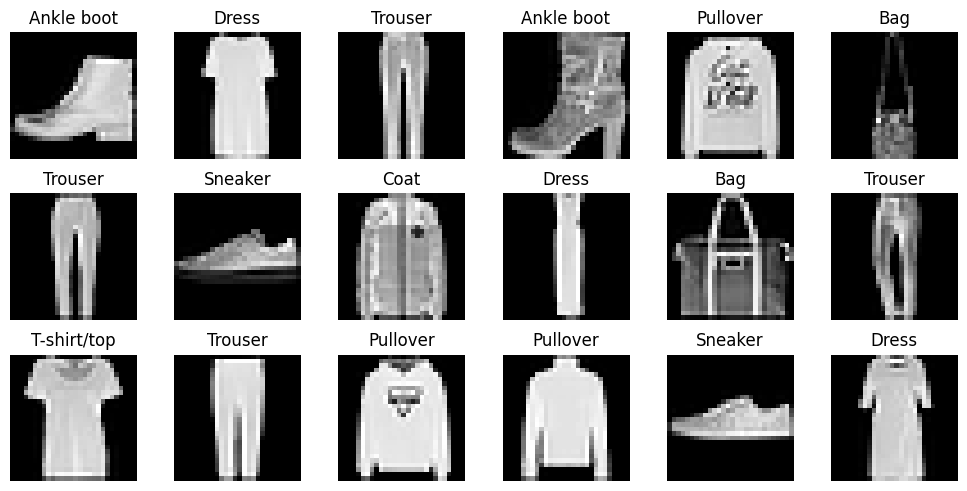

In [3]:
labels = [
    "T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"
]

print(f"Treino: {x_train.shape}, Validação: {x_val.shape}, Teste: {x_test.shape}")
print("Exemplo de rótulos (0-9):", labels)

# Grid de amostras aleatórias do conjunto de treino
fig, axes = plt.subplots(3, 6, figsize=(10, 5))
for i, ax in enumerate(axes.ravel()):
    idx = np.random.randint(0, len(x_train))
    ax.imshow(x_train[idx], cmap="gray")
    ax.set_title(labels[y_train[idx]])
    ax.axis("off")
plt.tight_layout()
plt.show()

# Questão 01: Rede neural simples

### Modelo

In [4]:
def build_model():
    model = keras.Sequential([ #modelo sequencial -> "clássico" com uma camada após a outra
        keras.layers.InputLayer(shape=(28, 28)), #imagens 28x28 pixels, cada pixel é um neurônio de entrada
        keras.layers.Flatten(), #transforma matriz 2D 28x28 em vetor 1D com 784 elementos
        keras.layers.Dense(64, activation='relu'), #ReLu como função de ativação não linear. 64 neurônios
        keras.layers.Dense(32, activation='relu'), #2 camadas ocultas para reduzir overfitting
        keras.layers.Dense(10, activation='softmax') #10 saídas(classes) possíveis. softmax normaliza saídas para somarem 1, como probabilidades
        #No cenário ideal, o neurônio de saída correspondente à classe correta terá saída 1, e os demais, 0.
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(), #aprendizado adaptativo
        loss='sparse_categorical_crossentropy', #ideal para classificação multiclasse com rótulos inteiros
        metrics=['accuracy'] #medida de desempenho simples
    )
    return model

### gerador de seeds

In [5]:
PRIME_STEP = 2654435761  # grande e usado em hashing
MASK32 = 0xFFFFFFFF
base = secrets.randbits(32)

# ===== Método para "espaçar" mais as seeds =====
# Ideia: usar uma base aleatória de 32 bits e aplicar um incremento grande e primo
# (ex: 2654435761 = constante de Knuth) gerando progressão pseudo-dispersada em 32 bits.
# Depois aplicamos uma mistura (hash simples) para minimizar correlação linear.
def spaced_seeds(n, base_seed, step):
    seeds = []
    for i in range(n):
        raw = (base_seed + i * step) & MASK32
        # Mistura extra: multiplicação + xor + shift (barato, evita sequência muito próxima)
        mixed = (raw * 0x9E3779B1) & MASK32
        mixed ^= (mixed >> 16)
        seeds.append(mixed)
    return seeds

seeds = spaced_seeds(5, base, PRIME_STEP)

### treinamento

In [6]:
histories = []
final_metrics = []

for i, seed in enumerate(seeds, start=1):
    print(f"\n=== Treinamento {i}/5 (seed={seed}) ===")
    keras.utils.set_random_seed(seed)
    model = build_model()
    
    h = model.fit(
        x_train, y_train,
        epochs=5,
        batch_size=128,
        verbose=0
    )
    histories.append(h)
    
    final_metrics.append({
        'run': i,
        'seed': seed,
        'final_train_loss': h.history['loss'][-1],
        'final_train_acc': h.history['accuracy'][-1]
    })
    
    print(f"Train - Loss: {h.history['loss'][-1]:.4f}, Acc: {h.history['accuracy'][-1]:.4f}")


=== Treinamento 1/5 (seed=633571605) ===
Train - Loss: 0.3480, Acc: 0.8726

=== Treinamento 2/5 (seed=631921821) ===
Train - Loss: 0.3480, Acc: 0.8726

=== Treinamento 2/5 (seed=631921821) ===
Train - Loss: 0.3523, Acc: 0.8749

=== Treinamento 3/5 (seed=630284297) ===
Train - Loss: 0.3523, Acc: 0.8749

=== Treinamento 3/5 (seed=630284297) ===
Train - Loss: 0.3394, Acc: 0.8773

=== Treinamento 4/5 (seed=628634753) ===
Train - Loss: 0.3394, Acc: 0.8773

=== Treinamento 4/5 (seed=628634753) ===
Train - Loss: 0.3439, Acc: 0.8767

=== Treinamento 5/5 (seed=626981636) ===
Train - Loss: 0.3439, Acc: 0.8767

=== Treinamento 5/5 (seed=626981636) ===
Train - Loss: 0.3508, Acc: 0.8740
Train - Loss: 0.3508, Acc: 0.8740


### gráficos

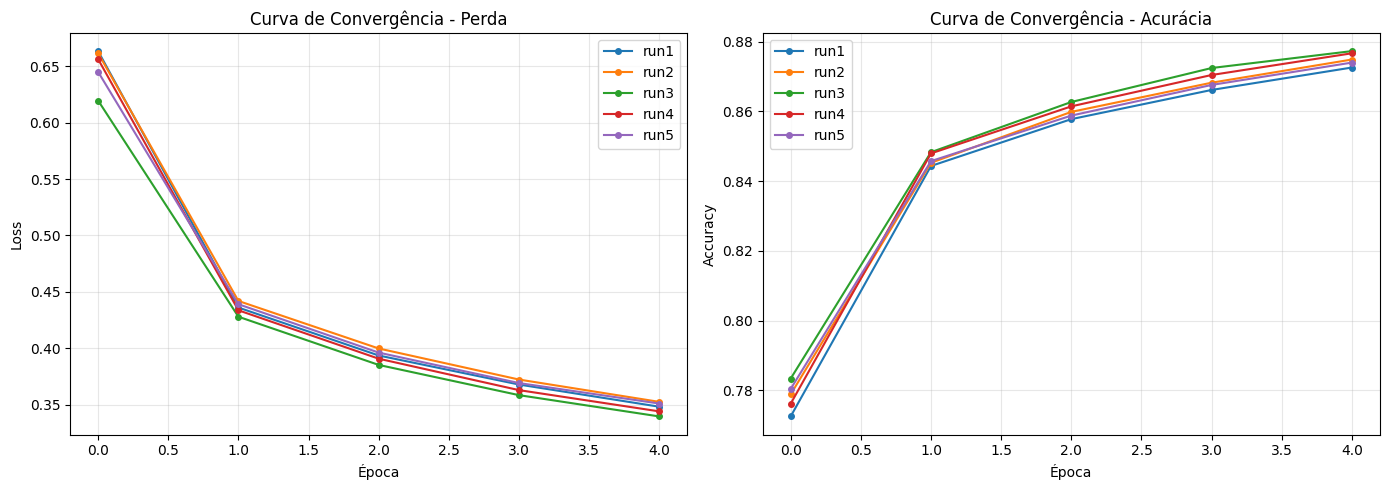


========== ESTABILIDADE ==========
Loss - média: 0.3469
Loss - desvio padrão: 0.0047
Acc  - média: 0.8751
Acc  - desvio padrão: 0.0017


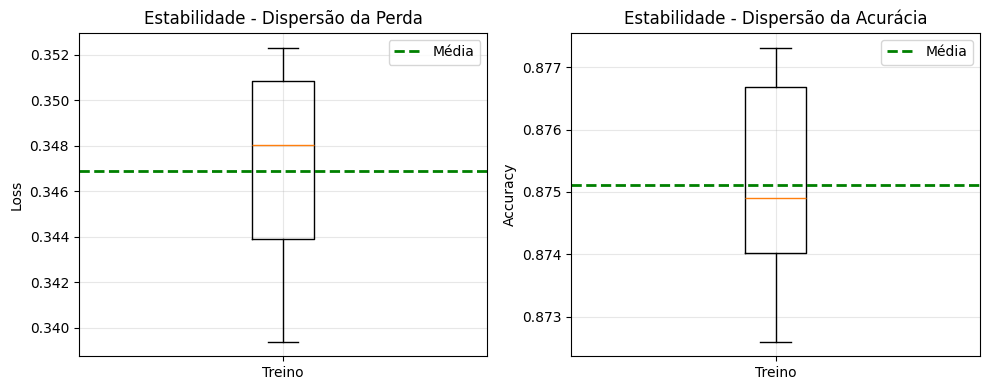


========== DESEMPENHO por seed ==========
Run 1 (seed=633571605): Loss=0.3480, Acc=0.8726
Run 2 (seed=631921821): Loss=0.3523, Acc=0.8749
Run 3 (seed=630284297): Loss=0.3394, Acc=0.8773
Run 4 (seed=628634753): Loss=0.3439, Acc=0.8767
Run 5 (seed=626981636): Loss=0.3508, Acc=0.8740


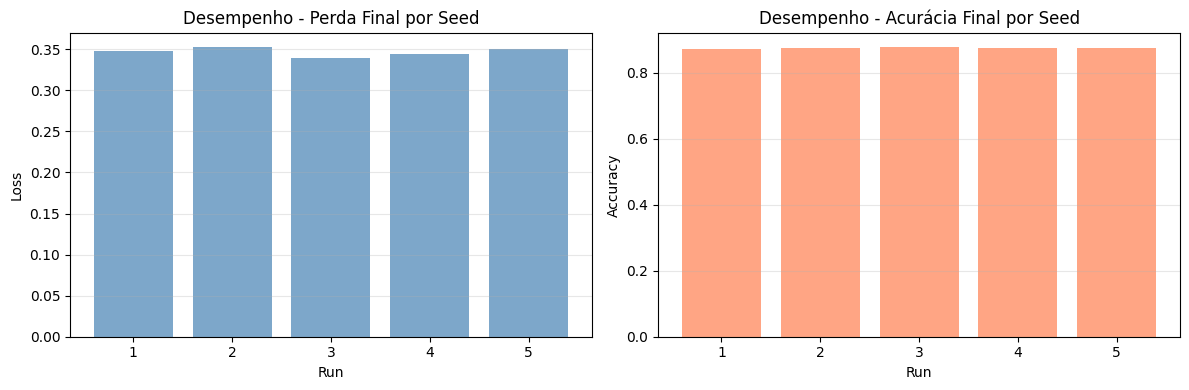


Seeds usadas: [633571605, 631921821, 630284297, 628634753, 626981636]


In [ ]:



# ========== CURVAS DE CONVERGÊNCIA ==========
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

#perda
for i, h in enumerate(histories, start=1):
    axes[0].plot(h.history['loss'], label=f'run{i}', marker='o', markersize=4)
axes[0].set_title('Curva de Convergência - Perda')
axes[0].set_xlabel('Época')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

#acurácia
for i, h in enumerate(histories, start=1):
    axes[1].plot(h.history['accuracy'], label=f'run{i}', marker='o', markersize=4)
axes[1].set_title('Curva de Convergência - Acurácia')
axes[1].set_xlabel('Época')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ========== ESTABILIDADE ==========
train_losses = [m['final_train_loss'] for m in final_metrics]
train_accs = [m['final_train_acc'] for m in final_metrics]

print("\n========== ESTABILIDADE ==========")
print(f"Loss - média: {np.mean(train_losses):.4f}")
print(f"Loss - desvio padrão: {np.std(train_losses):.4f}")
print(f"Acc  - média: {np.mean(train_accs):.4f}")
print(f"Acc  - desvio padrão: {np.std(train_accs):.4f}")

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
#5 seeds divididas entre bigode superior(máximo), limite superior da caixa, linha laranja (mediana), limite inferior da caixa, bigode inferior(mínimo)
axes[0].boxplot(train_losses, whis=(0, 100))
axes[0].set_title('Estabilidade - Dispersão da Perda')
axes[0].set_ylabel('Loss')
axes[0].set_xticklabels(['Treino'])
#axes[0].scatter([1]*len(train_losses), train_losses, color='red', zorder=2)
axes[0].axhline(y=np.mean(train_losses), color='green', linestyle='--', linewidth=2, label='Média')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].boxplot(train_accs, whis=(0, 100))
axes[1].set_title('Estabilidade - Dispersão da Acurácia')
axes[1].set_ylabel('Accuracy')
axes[1].set_xticklabels(['Treino'])
#axes[1].scatter([1]*len(train_accs), train_accs, color='red', zorder=2)
axes[1].axhline(y=np.mean(train_accs), color='green', linestyle='--', linewidth=2, label='Média')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ========== DESEMPENHO ==========
print("\n========== DESEMPENHO por seed ==========")
for m in final_metrics:
    print(f"Run {m['run']} (seed={m['seed']}): Loss={m['final_train_loss']:.4f}, Acc={m['final_train_acc']:.4f}")

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
x = np.arange(1, 6)

axes[0].bar(x, train_losses, alpha=0.7, color='steelblue')
axes[0].set_title('Desempenho - Perda Final por Seed')
axes[0].set_xlabel('Run')
axes[0].set_ylabel('Loss')
axes[0].set_xticks(x)
axes[0].grid(True, alpha=0.3, axis='y')

axes[1].bar(x, train_accs, alpha=0.7, color='coral')
axes[1].set_title('Desempenho - Acurácia Final por Seed')
axes[1].set_xlabel('Run')
axes[1].set_ylabel('Accuracy')
axes[1].set_xticks(x)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\nSeeds usadas:", seeds)